# Preprocessat Series Temporals

## Imports

In [1]:
import pandas as pd
import numpy as np
from typing import List

# Manipulació de dates
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta, TH

# Gràfics
import matplotlib.pyplot as plt
import seaborn as sns

# Transformacions
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Funcions estadístiques
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import boxcox

# Calendaris
from workalendar.europe.united_kingdom import UnitedKingdom
from workalendar.europe.spain import Spain
from workalendar.usa import California
import calendar
from astral.sun import sun
from astral import LocationInfo

# Feature engineering
import featuretools as ft
from featuretools.primitives import Minute, Hour, Day, Month, Year, Weekday
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Time Machine Learning
from sktime.datasets import load_arrow_head
from sktime.datatypes._panel._convert import from_nested_to_2d_array
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.shapelets import ContractedShapeletTransform

## Alertes estil

In [2]:
# Activació de les alertes d'estil
%load_ext pycodestyle_magic
%pycodestyle_on

## Transformacions

Generació de 10.000 nombres aleatoris entre 0 i 1 obeint una distribució lognormal

In [3]:
np.random.seed(0)
pts = 10000
# mu = 0, sigma = 1
vals = np.random.lognormal(0, 1.0, pts)

Text(0.5, 0, 'value range')

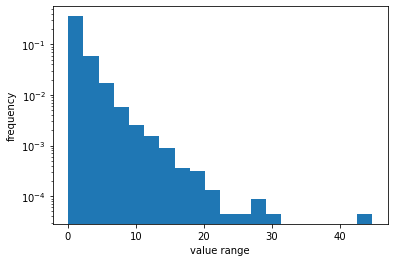

In [5]:
plt.hist(vals, bins=20, density=True)
plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range")

Aplica StandardScaler i després envia el resultat a la funció normal test per veure si estem davant d'una distribució normal
H0: Dist Normal; p < alpha, => rebuig H0

In [6]:
vals_mm = minmax_scale(vals)
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(vals_ss.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


Per tant, vals_ss no és normal

Què passa amb vals_mm?

In [7]:
_, p = normaltest(vals_mm.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


El mateix!

Veiem com entre vals i vals_ss només hem aconseguit variar l'escala

Text(0.5, 0, 'original')

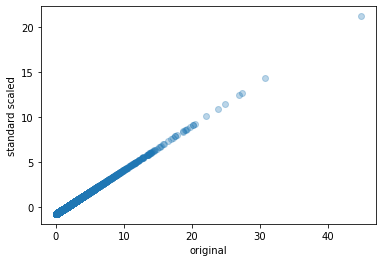

In [8]:
plt.scatter(vals, vals_ss, alpha=0.3)
plt.ylabel("standard scaled")
plt.xlabel("original")

Transformem ara les dades originals

In [9]:
log_transformed = np.log(vals)
_, p = kstest_normal(log_transformed)  # stats.normaltest
print(f"significance: {p:.2f}")

significance: 0.31


Amb aquesta significància no podem rebutjar que la distribució sigui normal. Si calculem la desviació estàndard i la mtjana, i visualitzem la distribució:

In [10]:
np.std(log_transformed)

0.9875565681761207

In [11]:
np.mean(log_transformed)

-0.01843372015826582

Text(0.5, 0, 'value range')

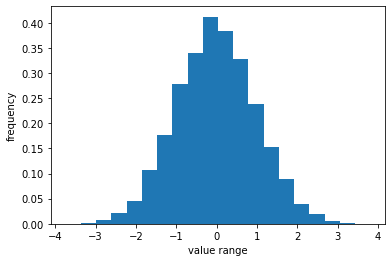

In [13]:
plt.hist(log_transformed, bins=20, density=True)
# plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range")

Podem aplicar també la transformació de Box-Cox, amb lambda=0. El resultat encara s'apropa més a una Gaussiana

In [14]:
vals_bc = boxcox(vals, 0.0)
_, p = normaltest(vals_bc)
print(f"significance: {p:.2f}")

significance: 0.46


Text(0.5, 0, 'value range')

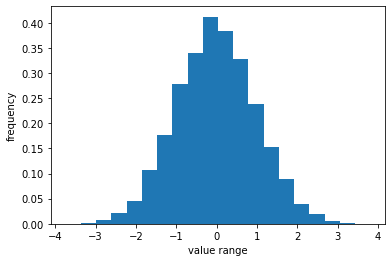

In [15]:
plt.hist(vals_bc, bins=20, density=True)
plt.ylabel("frequency")
plt.xlabel("value range")

## Imputació de valors

Simple imputer retorna, en els valors absents, la mitjana de cada columna

In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])
SimpleImputer()
df = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(df))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


## Atributs derivats de les dates

### Vacances

In [17]:
Spain().holidays()

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 6), 'Epiphany'),
 (datetime.date(2022, 4, 15), 'Good Friday'),
 (datetime.date(2022, 5, 1), 'Día del trabajador'),
 (datetime.date(2022, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2022, 10, 12), 'Fiesta nacional de España'),
 (datetime.date(2022, 11, 1), 'All Saints Day'),
 (datetime.date(2022, 12, 6), 'Día de la Constitución Española'),
 (datetime.date(2022, 12, 8), 'Immaculate Conception'),
 (datetime.date(2022, 12, 25), 'Christmas Day')]

In [20]:
def create_custom_holidays(year):
    """
    Crea una llista de dies de vacances
    Args:
        year (int): Any del que volem coneixer els dies de festa
    Returns:
        (dict): Clau: datetime del dia, valor: descripció
    """
    custom_holidays = California().holidays()
    custom_holidays.append(((datetime.datetime(year, 11, 1) +
                             relativedelta(weekday=TH(+4)) +
                             datetime.timedelta(days=1)).date(),
                            "Black Friday"))
    return {k: v for (k, v) in custom_holidays}


custom_holidays = create_custom_holidays(2021)

In [16]:
custom_holidays

{datetime.date(2021, 12, 31): 'New year (Observed)',
 datetime.date(2022, 1, 1): 'New year',
 datetime.date(2022, 1, 17): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2022, 2, 21): "Washington's Birthday",
 datetime.date(2022, 3, 31): 'Cesar Chavez Day',
 datetime.date(2022, 5, 30): 'Memorial Day',
 datetime.date(2022, 7, 4): 'Independence Day',
 datetime.date(2022, 9, 5): 'Labor Day',
 datetime.date(2022, 11, 11): 'Veterans Day',
 datetime.date(2022, 11, 24): 'Thanksgiving Day',
 datetime.date(2022, 11, 25): 'Thanksgiving Friday',
 datetime.date(2022, 12, 25): 'Christmas Day',
 datetime.date(2022, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2021, 11, 26): 'Black Friday'}

In [21]:
def is_holiday(current_date):
    """
    Determinar si un determinat dia és festa
    Args:
        current_date (datetime.date): dia a determinar

    Returns:
        (Bool): True si ek dia és festiu
    """
    return custom_holidays.get(current_date, False)


today = datetime.date(2021, 4, 11)
is_holiday(today)

False

### Date Annotations

monthrange retorna el primer dia de la setmana del mes, i el nombre de dies del mes. Dilluns=0, Diumenge=6

In [22]:
calendar.monthrange(2021, 1)

(4, 31)

Altres atributs

In [23]:
def year_anchor(current_date):
    """
    Calcula el nombre de dies de l'any transcorreguts i els que falten

    Args:
        current_date (datetime.date): Dia de referència

    Returns:
        (tupla): Nombre de dies transcorreguts i dies que falten per cap d'any
    """
    return ((current_date - date(current_date.year, 1, 1)).days,
            (date(current_date.year, 12, 31) - current_date).days,)


year_anchor(today)

(100, 264)

In [26]:
def month_anchor(dia):
    """
    Igual a la funció anterior però dins del mes

    Args:
        dia (datetime.date): Dia de referència

    Returns:
        (tupla): Nombre dies transcorreguts i dies que falten pel final de mes
    """
    last_day = calendar.monthrange(dia.year, dia.month)[0]

    return ((dia - datetime.date(dia.year, dia.month, 1)).days,
            (dia - datetime.date(dia.year, dia.month, last_day)).days,)


month_anchor(today)

(10, 8)

### Últim divendres de mes del dia escollit (21/04/2021)

In [28]:
def get_last_friday(dia, weekday=calendar.FRIDAY):
    """
    Calcula en quin dia cau l'últim divendres del mes

    Args:
        dia (datetime): dia actual
        weekday (dia_setmana): Dia de la setmana buscat. Def: Friday

    Returns:
        (int): Dia del més que correspon a l'últim divendres
    """
    return max(week[weekday]
               for week in calendar.monthcalendar(dia.year, dia.month))


get_last_friday(today)

30

### Estacions de l'any

In [30]:
YEAR = 2021

# Creem una llista de tuples per a les estacions
seasons = [('winter', (date(YEAR,  1,  1),  date(YEAR,  3, 20))),
           ('spring', (date(YEAR,  3, 21),  date(YEAR,  6, 20))),
           ('summer', (date(YEAR,  6, 21),  date(YEAR,  9, 22))),
           ('autumn', (date(YEAR,  9, 23),  date(YEAR, 12, 20))),
           ('winter', (date(YEAR, 12, 21),  date(YEAR, 12, 31)))]


def is_in_interval(dia, seasons):
    """_summary_

    Args:
        dia (datetime.date): dia del que busquem saber l'estació
        seasons (list): llista amb inicis i finals de les estacions

    Returns:
        (String): Estació de l'any
    """
    return next(season for season, (start, end) in seasons
                if start <= dia.replace(year=YEAR) <= end)


is_in_interval(today, seasons)

'spring'

### Sol i Lluna

In [33]:
CITY = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)


def get_sunrise_dusk(dia):
    """
    Calcula les hores de sol en un dia i lloc
    Args:
        dia (datetime.date): Dia del que busquem eixida i posta
    Returns:
        (Float): Hores de llum solar del dia i lloc
    """
    s = sun(CITY.observer, date=dia)
    sunrise = s['sunrise']
    dusk = s['dusk']
    return (sunrise - dusk).seconds / 3600


get_sunrise_dusk(today)

9.788055555555555

### Dies Laborables

In [36]:
def get_business_days(dia):
    """
    Calcula els dies laborables d'un mes
    Args:
        dia (datetime.date): dia del mes que volem saber
    Returns:
        (tupla): Dies laborables i dies festius del mes
    """
    last_day = calendar.monthrange(dia.year, dia.month)[1]
    rng = pd.date_range(dia.replace(day=1),
                        periods=last_day,
                        freq='D')
    business_days = pd.bdate_range(rng[0], rng[-1])
    return len(business_days), last_day - len(business_days)


get_business_days(date.today())

(20, 8)

## Extracció automàtica d'atributs

Featuretools calcula moltes funcions relacionades amb els dies. 

In [38]:
data = pd.DataFrame({'Time': ['2014-01-01 01:41:50',
                              '2014-01-01 02:06:50',
                              '2014-01-01 02:31:50',
                              '2014-01-01 02:56:50',
                              '2014-01-01 03:21:50'],
                     'Target': [0, 0, 0, 0, 1]})
data['index'] = data.index
es = ft.EntitySet('My EntitySet')
es.entity_from_dataframe(entity_id='main_data_table',
                         index='index',
                         dataframe=data,
                         time_index='Time')
fm, features = ft.dfs(entityset=es,
                      target_entity='main_data_table',
                      trans_primitives=[Minute,
                                        Hour,
                                        Day,
                                        Month,
                                        Year,
                                        Weekday])

In [33]:
fm

,Target,DAY(Time),HOUR(Time),MINUTE(Time),MONTH(Time),WEEKDAY(Time),YEAR(Time)
index,,,,,,,
0,0,1,1,41,1,2,2014
1,0,1,2,6,1,2,2014
2,0,1,2,31,1,2,2014
3,0,1,2,56,1,2,2014
4,1,1,3,21,1,2,2014


Tsfresh també pot proporcionar ajuda

In [39]:
settings = ComprehensiveFCParameters()
extract_features(data, column_id='Time', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


,index__variance_larger_than_standard_deviation,index__has_duplicate_max,index__has_duplicate_min,index__has_duplicate,index__sum_values,index__abs_energy,index__mean_abs_change,index__mean_change,index__mean_second_derivative_central,index__median,...,Target__permutation_entropy__dimension_5__tau_1,Target__permutation_entropy__dimension_6__tau_1,Target__permutation_entropy__dimension_7__tau_1,Target__query_similarity_count__query_None__threshold_0.0,"Target__matrix_profile__feature_""min""__threshold_0.98","Target__matrix_profile__feature_""max""__threshold_0.98","Target__matrix_profile__feature_""mean""__threshold_0.98","Target__matrix_profile__feature_""median""__threshold_0.98","Target__matrix_profile__feature_""25""__threshold_0.98","Target__matrix_profile__feature_""75""__threshold_0.98"
2014-01-01 01:41:50,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:06:50,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:31:50,0.0,0.0,0.0,0.0,2.0,4.0,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:56:50,0.0,0.0,0.0,0.0,3.0,9.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:21:50,0.0,0.0,0.0,0.0,4.0,16.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ROCKET

SKtime, la llibreria que conté ROCKET, representa les dades en forma de Dataframes recursius. Cada columna representa un atribut, però a a cada fila hi ha una sèrie temporal. Cada cel·la conté un array amb tots els valors d'un atribut al llarg del temps.

Això permet guardar múltiples sèries temporals en el mateix dataframe. Per sort, sklearn forneix funcions per a accedir convenientment a les dades.

In [40]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
from_nested_to_2d_array(X_train).head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
0,-1.9630,-1.9578,-1.9561,-1.9383,-1.8967,-1.8699,-1.8387,-1.8123,-1.7364,-1.6733,...,-1.5839,-1.6553,-1.7192,-1.7509,-1.7963,-1.8413,-1.8843,-1.9054,-1.9239,-1.9092
1,-1.7746,-1.7740,-1.7766,-1.7307,-1.6963,-1.6574,-1.6362,-1.6098,-1.5434,-1.4862,...,-1.4717,-1.4847,-1.5400,-1.5902,-1.6357,-1.6400,-1.6787,-1.7292,-1.7757,-1.7893
2,-1.8660,-1.8420,-1.8350,-1.8119,-1.7644,-1.7077,-1.6483,-1.5826,-1.5315,-1.4936,...,-1.5841,-1.6523,-1.6846,-1.7440,-1.7991,-1.8291,-1.8758,-1.8625,-1.8634,-1.8465
3,-2.0738,-2.0733,-2.0446,-2.0383,-1.9590,-1.8745,-1.8056,-1.7310,-1.7127,-1.6280,...,-1.6789,-1.7437,-1.8198,-1.8581,-1.8861,-1.9512,-2.0129,-2.0270,-2.0734,-2.0753
4,-1.7463,-1.7413,-1.7227,-1.6986,-1.6772,-1.6304,-1.5794,-1.5512,-1.4740,-1.4594,...,-1.5471,-1.6071,-1.6351,-1.6863,-1.6913,-1.7169,-1.7407,-1.7434,-1.7627,-1.7634


Com veiem, hi ha un únic atribut, 0, i cada filera és una sèrie temporal

Ara apliquem ROCKET amb 1000 kernels (per defecte: 10.000) per a obtenir la transformació

In [42]:
rocket = Rocket(num_kernels=1000)
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
X_train_transform.shape

(36, 2000)

## Shapelets

In [43]:
shapelets_transform = ContractedShapeletTransform(
    time_contract_in_mins=1,
    num_candidates_to_sample_per_case=10,
    verbose=0)
shapelets_transform.fit(X_train, y_train)

ContractedShapeletTransform(num_candidates_to_sample_per_case=10,
                            time_contract_in_mins=1)

In [44]:
X_train_transform = shapelets_transform.transform(X_train)

In [45]:
X_train_transform

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.425224,0.133638,0.204021,0.257050,0.158281,0.171958,0.150097,1.424467,0.097601,0.368838,0.131081,0.016675,0.008099,0.029546,0.016014,0.125658,0.090589,0.077743
1,0.858237,0.193746,0.265619,0.648669,0.111854,0.024709,0.028594,1.415290,0.045375,0.067862,0.179164,0.010308,0.007796,0.009461,0.020074,0.075584,0.062378,0.093963
2,0.690759,0.211582,0.310732,0.570994,0.156333,0.060049,0.038065,1.460121,0.031889,0.130717,0.165630,0.012593,0.008186,0.021762,0.019687,0.069033,0.095612,0.189812
3,0.181270,0.122085,0.029804,0.114984,0.269639,0.446133,0.369263,1.275535,0.404717,0.782436,0.100716,0.053725,0.003258,0.061343,0.052785,0.197587,0.067792,0.088265
4,0.737389,0.165319,0.247438,0.582669,0.067152,0.014405,0.013705,1.325250,0.018787,0.142533,0.139341,0.026822,0.008686,0.040592,0.025775,0.138027,0.137032,0.052369
5,0.892243,0.142192,0.267835,0.605526,0.092585,0.058339,0.054452,1.339301,0.099179,0.075245,0.083709,0.080822,0.009467,0.008213,0.072115,0.013609,0.500169,0.083417
6,0.245074,0.000000,0.152721,0.225594,0.503883,0.506510,0.338643,1.004125,0.579437,0.699475,0.063954,0.097586,0.003611,0.065516,0.058896,0.062259,0.113530,0.045348
7,0.830644,0.153936,0.285712,0.658002,0.054148,0.000000,0.036444,1.310321,0.037374,0.144163,0.151470,0.042180,0.008056,0.054010,0.038726,0.144584,0.133604,0.126833
8,0.812087,0.232856,0.271966,0.620641,0.146059,0.044843,0.038028,1.434238,0.038525,0.074108,0.216882,0.008428,0.008380,0.011519,0.009858,0.058785,0.088841,0.151115
9,0.161922,0.069993,0.029235,0.375352,0.467022,0.675901,0.439223,1.039284,0.668404,1.016044,0.159526,0.054702,0.016215,0.038365,0.097392,0.140843,0.175019,0.095052
